# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Import the FBM healthy eryth

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200718.h5ad')

In [4]:
adata.raw = adata

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell             327
CD8 T cell             171
CD14 monocyte         8787
CD56 bright NK         450
CMP                    425
                      ... 
schwann cells            9
sinusoidal EC          550
stromal macrophage    1493
tDC                    193
tip EC                 363
Length: 64, dtype: int64

In [6]:
celltypes = ['MEMP', 'MEP', 'early erythroid', 'mid erythroid', 'late erythroid']

In [7]:
adata = adata[adata.obs['cell.labels'].isin(celltypes)].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
MEMP                  16
MEP                  269
early erythroid     7534
late erythroid      4649
mid erythroid      14408
dtype: int64

In [9]:
cell_numbers = adata.obs.groupby(["fetal.ids"]).apply(len)
cell_numbers

fetal.ids
F21_male_16+2PCW       604
F29_female_17+0PCW    1135
F30_male_14+3PCW       841
F38_male_12PCW         519
F41_female_16PCW      3204
F45_female_13+6PCW     785
F50_female_15PCW      6660
F51_female_15PCW      9454
SB19PCW               3674
dtype: int64

In [10]:
adata = adata[adata.obs['fetal.ids'].isin(["F38_male_12PCW", "F45_female_13+6PCW"])].copy()

In [11]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].replace(["MEP", "MEMP"], ["MEP_MEMP", "MEP_MEMP"])

In [12]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
MEP_MEMP            27
early erythroid    452
late erythroid     186
mid erythroid      639
dtype: int64

In [13]:
cell_numbers = adata.obs.groupby(["fetal.ids"]).apply(len)
cell_numbers

fetal.ids
F38_male_12PCW        519
F45_female_13+6PCW    785
dtype: int64

In [14]:
adata.shape

(1304, 33712)

In [15]:
adata.obs["dataset"] = "fbm"
fbm = adata

In [16]:
fbm.shape

(1304, 33712)

# Import the DS eryth cells

In [17]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/downs_bm/data/downs_raw_dr_20200714.h5ad')

In [18]:
adata.shape

(8622, 33694)

In [19]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          4
CD8 T cell                  55
CD14 monocyte              252
CD56 bright NK              36
CMP                         37
DC1                         16
DC2                         94
DC3                         98
HSC                         45
ILC precursor               13
MEMP                        42
MK                          25
MOP                        350
MSC                         18
Treg                         8
chondrocyte                  4
early B cell                23
early MK                     7
early erythroid            766
endothelium                 37
eo/baso/mast precursor      40
eosinophil                  41
late erythroid            3341
macrophage                  64
mast cell                   27
mature B cell               20
mature NK                   69
mid erythroid             2082
myelocyte                  218
neutrophil                 245
osteoblast                  11
osteoclast                 

In [20]:
adata = adata[adata.obs['cell.labels'].isin(['MEMP', 'early erythroid', 'mid erythroid', 
                                                    'late erythroid'])].copy()

In [21]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
MEMP                 42
early erythroid     766
late erythroid     3341
mid erythroid      2082
dtype: int64

In [22]:
adata.obs["dataset"] = "ds_fbm"
ds_fbm = adata

In [23]:
ds_fbm.shape

(6231, 33694)

# Combine the datasets

In [24]:
from scipy import sparse

objects = [ds_fbm, fbm]

for i in objects:
    array_vals = i.X
    i.X = sparse.csr_matrix(i.X)
    i.raw = i
    i.X = array_vals

In [25]:
merged = ds_fbm.concatenate(fbm, index_unique=None, join='inner')

In [26]:
merged.shape

(7535, 33694)

In [27]:
cell_numbers = merged.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
MEMP                 42
MEP_MEMP             27
early erythroid    1218
late erythroid     3527
mid erythroid      2721
dtype: int64

In [28]:
merged.obs["dataset_cell.labels"] = merged.obs["dataset"].astype(str) + '_' + merged.obs["cell.labels"].astype(str)

In [29]:
cell_numbers = merged.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
ds_fbm_MEMP                 42
ds_fbm_early erythroid     766
ds_fbm_late erythroid     3341
ds_fbm_mid erythroid      2082
fbm_MEP_MEMP                27
fbm_early erythroid        452
fbm_late erythroid         186
fbm_mid erythroid          639
dtype: int64

# Pre-process the data

In [30]:
adata=merged

In [31]:
# normalise count data 
sc.pp.normalize_total(adata)

In [32]:
# log the count data 
sc.pp.log1p(adata)

In [33]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [34]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Import cell cycling genes

In [35]:
#Score cell cycle and visualize the effect:
# load file in
cc_genes_file = '/Users/b8058304/Documents/PhD_work/Coding/bm/resources_for_pipelines/cell_cycle_makosco.csv'
cc_genes = pd.read_csv(cc_genes_file, delimiter=',')
# removing na from s and g2m list
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2/M'].dropna()

In [36]:
y_genes = s_genes.tolist()
no_trail = []

for x in y_genes:
    y = x.strip()
    no_trail.append(y)
    
s_genes = no_trail 

In [37]:
y_genes = g2m_genes.tolist()
no_trail = []

for x in y_genes:
    y = x.strip()
    no_trail.append(y)
    
g2m_genes = no_trail 

In [38]:
s_genes_mm = adata.var_names[np.isin(adata.var_names, s_genes)]

In [39]:
g2m_genes_mm = adata.var_names[np.isin(adata.var_names, g2m_genes)]

In [40]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm, g2m_genes=g2m_genes_mm)

In [41]:
adata.obs["phase_combined"] = adata.obs["phase"].replace(["G2M", "S"], ["G2M/S", "G2M/S"])

In [42]:
adata.obs["S/G2M_score_combined"] = (adata.obs["G2M_score"] + adata.obs["S_score"])/2

# Reorder the celltype/tissue metadata col (in prep for heatmap)

In [43]:
# order tissue_cell.labels column

adata.obs["dataset_cell.labels"].unique()

array(['ds_fbm_early erythroid', 'ds_fbm_late erythroid',
       'ds_fbm_mid erythroid', 'ds_fbm_MEMP', 'fbm_early erythroid',
       'fbm_mid erythroid', 'fbm_late erythroid', 'fbm_MEP_MEMP'],
      dtype=object)

In [44]:
# order tissue_cell.labels column

adata.obs["dataset_cell.labels"] = adata.obs["dataset_cell.labels"].astype("category")

adata.obs["dataset_cell.labels"] = adata.obs["dataset_cell.labels"].cat.reorder_categories(['ds_fbm_MEMP',
         'ds_fbm_early erythroid', 'ds_fbm_mid erythroid', 'ds_fbm_late erythroid',
         'fbm_MEP_MEMP', 'fbm_early erythroid', 'fbm_mid erythroid', 'fbm_late erythroid'])

In [45]:
adata.obs["dataset_cell.labels"].unique()

[ds_fbm_early erythroid, ds_fbm_late erythroid, ds_fbm_mid erythroid, ds_fbm_MEMP, fbm_early erythroid, fbm_mid erythroid, fbm_late erythroid, fbm_MEP_MEMP]
Categories (8, object): [ds_fbm_early erythroid, ds_fbm_late erythroid, ds_fbm_mid erythroid, ds_fbm_MEMP, fbm_early erythroid, fbm_mid erythroid, fbm_late erythroid, fbm_MEP_MEMP]

In [46]:
# save cell cycle scores within metadata as a dataframe (called enrichement scores)
adata.obs["labels"] = adata.obs["dataset_cell.labels"]
meta = pd.DataFrame(adata.obs)
enrichment_scores_df = meta[meta.columns[-2:]]
enrichment_scores_df

,S/G2M_score_combined,labels
index,,
AAACCTGAGTACGTTC-1-DSOX4,0.190346,ds_fbm_early erythroid
AAACCTGCAAGCGATG-1-DSOX4,0.030961,ds_fbm_late erythroid
AAACGGGGTTATGCGT-1-DSOX4,0.015899,ds_fbm_late erythroid
AAAGATGGTAGCCTCG-1-DSOX4,-0.021645,ds_fbm_late erythroid
AAAGATGTCTTATCTG-1-DSOX4,0.279530,ds_fbm_early erythroid
...,...,...
F45_boneMarrow_CD45-_FCAImmP7579221_3prime_TTGGCAACATAGAAAC,0.220400,fbm_mid erythroid
F45_boneMarrow_CD45-_FCAImmP7579221_3prime_TTGTAGGGTAGCTGCC,0.003146,fbm_mid erythroid
F45_boneMarrow_CD45-_FCAImmP7579221_3prime_TTGTAGGTCACCATAG,-0.017405,fbm_late erythroid


In [47]:
# calculate mean enrichment scores by celltype
mean_enrichment_scores_df = enrichment_scores_df.groupby('labels').mean()
mean_enrichment_scores_df = mean_enrichment_scores_df.T
mean_enrichment_scores_df = mean_enrichment_scores_df.sort_index()
mean_enrichment_scores_df

labels,ds_fbm_MEMP,ds_fbm_early erythroid,ds_fbm_mid erythroid,ds_fbm_late erythroid,fbm_MEP_MEMP,fbm_early erythroid,fbm_mid erythroid,fbm_late erythroid
S/G2M_score_combined,-0.093773,0.19089,0.321319,-0.000416,-0.160337,0.038812,0.060172,-0.00469


# Run heatmap

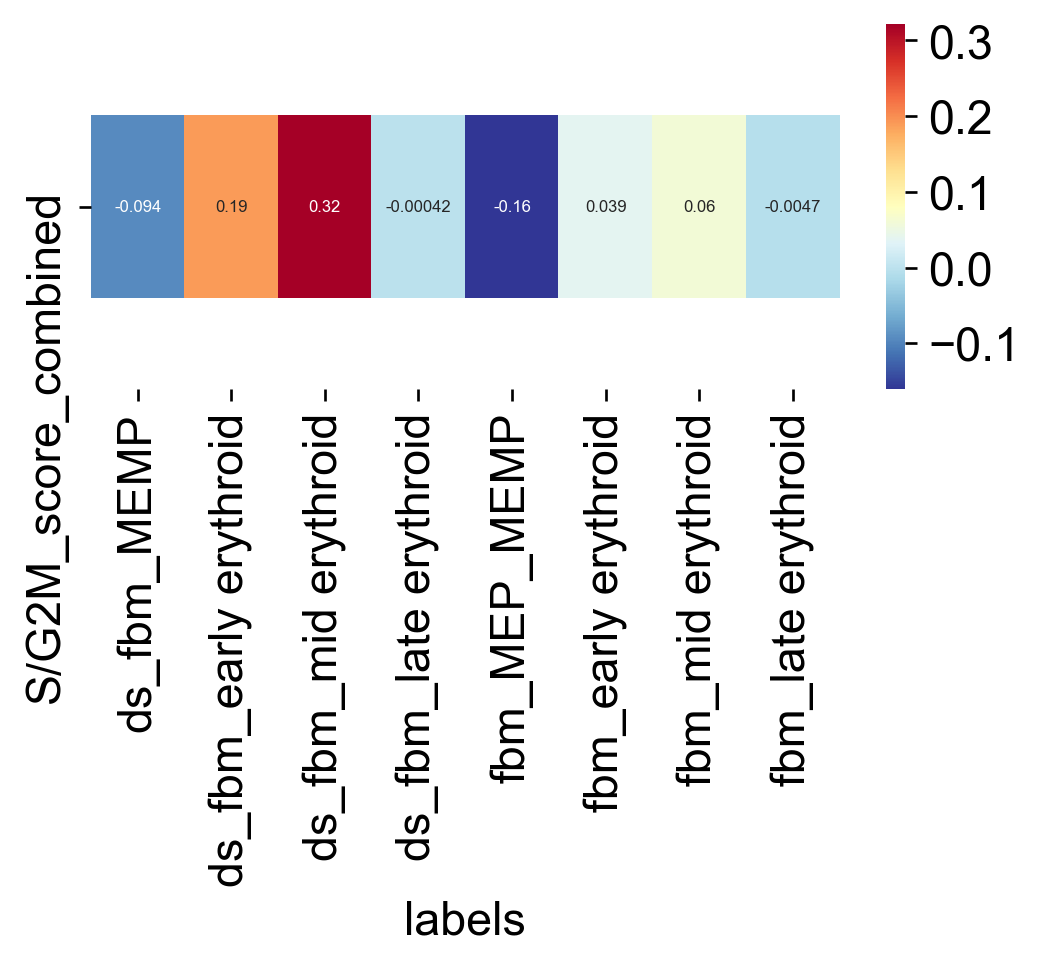

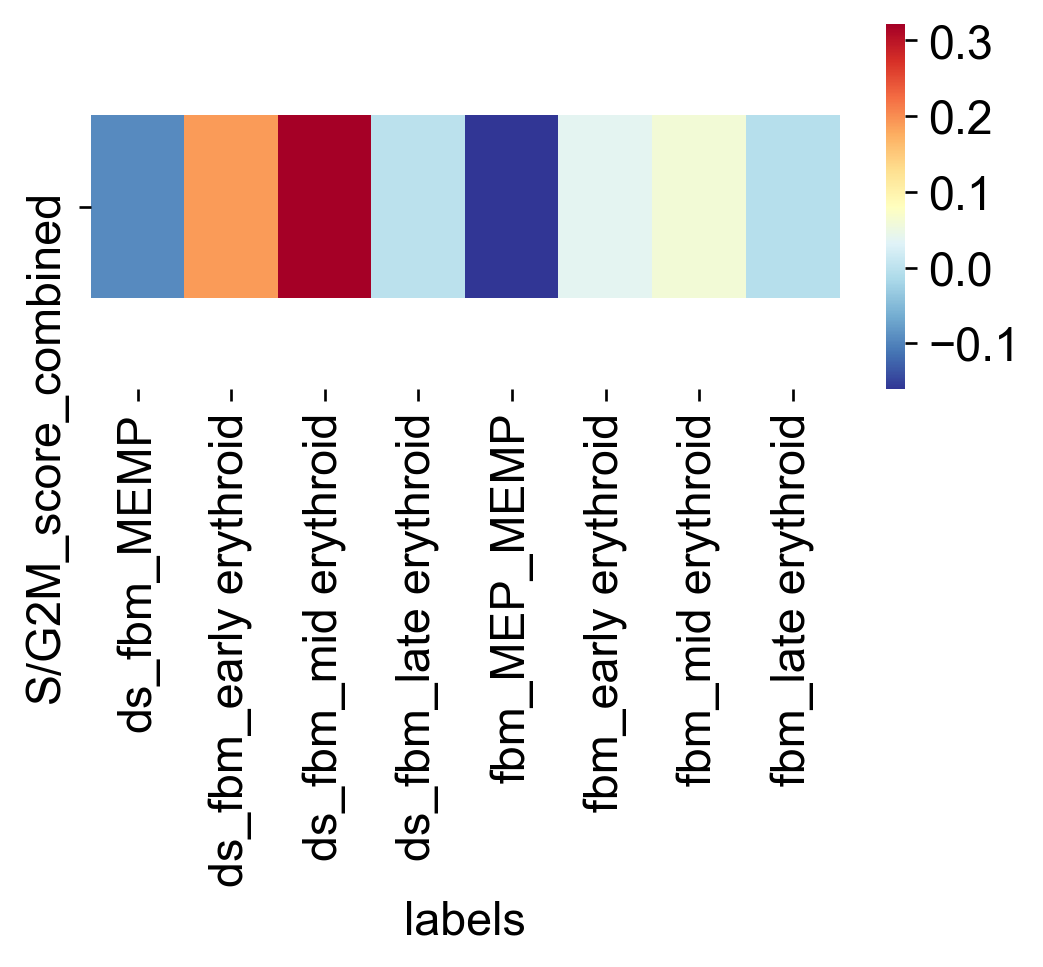

In [48]:
plt.figure(figsize=(5, 2))
fig = sns.heatmap(mean_enrichment_scores_df, annot=True, fmt=".2", annot_kws={"size": 5}, cmap="RdYlBu_r").get_figure() #xticklabels=cell_label_order, yticklabels=cell_label_order,
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
fig.savefig("figures/figs5b_no-ds_ds_eryth_cycle_comparison_numbers_yes_20200728.pdf")

plt.figure(figsize=(5, 2))
fig = sns.heatmap(mean_enrichment_scores_df, cmap="RdYlBu_r").get_figure() 
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
fig.savefig("figures/figs5b_no-ds_ds_eryth_cycle_comparison_numbers_no_20200728.pdf")

# Save the data

In [49]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [50]:
adata.X

<7535x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 12973058 stored elements in Compressed Sparse Row format>

In [51]:
adata.raw.X

<7535x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 14190227 stored elements in Compressed Sparse Row format>

In [52]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs5b_no-ds_ds_eryth_cycle_20200728.h5ad")

... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'mad_prd' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical
... storing 'phase' as categorical
... storing 'phase_combined' as categorical
